# Precess parameters
- AC:    
    - carburizing time: 2h - 3600s
    - Environment Carbon potential for entitle 2h: 1%
- LPC:
    - Boost - diffuse time: 10mins - 20mins - 10mins - 30mins - 10mins - 40mins
    - Environment carbon potential during boosting period: 1.2%
    
# Material parameters
- Carbon diffusivity of steel at 900C
    - With 1% carbon environment: 2E-5
    - With 1.2% carbon environment: 2.2E-5


# FEniCS implementation

In [1]:
from fenics import *
import numpy as np

## Mesh and Functionspace
- Computation domain is a rectangle which is defined by 2 poins `(0,0)` and `(xmax,ymax)`. Here we will define `xmax = ymax = 0.1`
- Meshing of domain:
    - Vertical edges will get discrete equally to `ny=100`
    - Horizontal edges will get discrete equally to `nx=5` <br>

**Notes:**<br>
- Units: Python doesn't have unit system, so we will have to define it consistently:
    - Length: mm
    - Time: s
    - Temperature: Celcius
    - Diffussion coefficient: $mm^2/s$
- Meshing: In carburising sometime it's a matter of $\mu m$ so in this example, we will have `mesh` that has smallest edge $$ymax/ny = 0.1/100mm = 0.001mm = 1\mu m$$

In [2]:
# Create mesh and define function space
xmax=0.5
ymax=0.5
nx = 5
ny = 500
mesh = RectangleMesh(Point(0, 0), Point(xmax, ymax), nx, ny)
V = FunctionSpace(mesh, 'P', 1)

Calling FFC just-in-time (JIT) compiler, this may take some time.


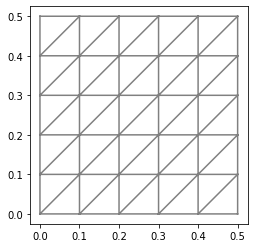

In [3]:
# This is our mesh if it was much coarser
plot(RectangleMesh(Point(0, 0), Point(xmax, ymax), 5, 5))

## Atmosphere Carburizing case

### Initial condition
- All the nodes will have initial carbon content of `C_ini` = 0.002 (or 0.2%)
- Intuitively, `C_cal` stands for Carbon_content_calculated for every node, will be calculated in each time step, initially is `C_ini` entirely

In [4]:
# Initial condition
C_ini = Constant(0.004)
C_cal= interpolate(C_ini, V)

### User input parameters
- `AC_time`: time of AC process[s]
- `num_steps`: number of time steps for calculation
- `D_AC`: diffusion coefficient [$mm^2/s$]
- `C_env_AC`: Carbon potential of environment

In [5]:
AC_time= 1800           # final time"
num_steps = 3600     # number of time steps
D_AC =  Constant(2E-5) # Dummy number
C_env_AC = Constant(0.01)

### Solver

In [6]:
# Define boundary condition on top surface
tol=1E-14
def on_top ( x, on_boundary ):
    return ( ymax - tol <= x[1] )
bc_AC = DirichletBC(V, C_env_AC, on_top)

# Apply boundary condition on FunctionSpace V
bc_AC.apply(C_cal.vector())

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(0)

dt = AC_time / num_steps # time step size

F = u*v*dx + D_AC*dt*dot(grad(u), grad(v))*dx - (C_cal + dt*f)*v*dx
a, L = lhs(F), rhs(F)


# vtkfile = File('AC/solution.pvd') # uncomment this line if you want to Create VTK file for saving solution

# Time-stepping
C_tracker_AC = [C_cal.compute_vertex_values()]
u = Function(V)
t = 0
for k in range(num_steps):    
    t += dt             # Update current time    
    solve(a == L, u,bc_AC) # Compute solution    
    C_cal.assign(u)     # Update previous solution
    
#     vtkfile << (u, t) # uncomment this line if you want to save to file and plot solution
    
    C_tracker_AC.append(C_cal.compute_vertex_values())
    
    # vtk file

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


### Results

#### C_cal
`C_cal` is a dolfin.function.function.Function which store solution for final step. 
`C_cal` can be used:
- `plot(C_cal)`
- ...

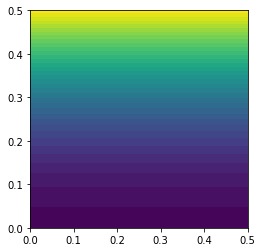

In [7]:
plot(C_cal)

#### C_tracker_AC
`C_tracker_AC` is a 2D array store values of carbon concentration of every node at every timestep

In [8]:
C_tracker_AC = np.stack(C_tracker_AC, axis=0)

#### What to post-process?
- `viz_nodes`: all nodes ID with same horizontal value 0.2, will be used for Carbon vs depth graph
- `node_D0`: node ID of the node on top surface, with position (0.2,0.5)
- `node_D0`: node ID of the node on 100$\mu m$ depth, with position (0.2,0.4)
- `depth`: list that stores depth levels for carbon vs depth graph
- `time`: list store time of each calculation step, used to visualize carbon concentration during process

**All will be save to LPC_AC_post.json for post-processing**


- Carbon content of all viz_nodes will be save to `AC_viz_nodes_results.csv`

In [9]:
viz_nodes = []
for i in range(len(mesh.coordinates())):    
    if mesh.coordinates()[i][0]==0.2:
        viz_nodes.append(i)
        if mesh.coordinates()[i][1]==0.5:   node_D0=i 
        if mesh.coordinates()[i][1]==0.1: node_D100=i

In [10]:
depths = np.arange(0, 501, 1).tolist()
times  = np.arange(0, 1800.5, 0.5).tolist()

In [11]:
import json
data = {
    "depths": depths,
    "times": times,
    "viz_nodes": viz_nodes,
    "node_D0": node_D0,
    "node_D100": node_D100   
}
with open("LPC_AC_post.json", "w") as write_file:
    json.dump(data, write_file)

In [14]:
import pandas as pd
df = pd.DataFrame(data=C_tracker_AC[:,viz_nodes]).iloc[:, ::-1]

df.to_csv('AC_viz_nodes_results.csv',header=False,index=False)

## LPC case

### Initial condition
- All the nodes will have initial carbon content of `C_ini` = 0.002 (or 0.2%)
- Intuitively, `C_cal` stands for Carbon_content_calculated for every node, will be calculated in each time step, initially is `C_ini` entirely

In [15]:
# Initial condition
C_ini = Constant(0.004)
C_cal= interpolate(C_ini, V)

### User input parameters
- `boost_time`: array of boosting periods [s]
- `diffuse_time`: array of diffusing periods [s]
- `num_steps`: number of time steps for calculation of whole LPC process
- `D_LPC`: diffusion coefficient [$mm^2/s$]
- `C_env_LPC`: Carbon potential of environment during boost time

In [16]:
number_of_bd = int(3)
boost_time   = [150,150,150] 
diffuse_time = [300,450,600] 

LPC_time = 1800
num_steps = 3600

D_LPC =  Constant(2.2E-5) 
C_env_LPC = Constant(0.012)

### Solver

In [17]:
# Define boundary condition on top surface
tol=1E-14
def on_top ( x, on_boundary ):
    return ( ymax - tol <= x[1] )
bc_LPC = DirichletBC(V, C_env_LPC, on_top)

# Apply boundary condition on FunctionSpace V
bc_LPC.apply(C_cal.vector())

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(0)

dt = LPC_time / num_steps # time step size

F = u*v*dx + D_LPC*dt*dot(grad(u), grad(v))*dx - (C_cal + dt*f)*v*dx
a, L = lhs(F), rhs(F)

# Time-stepping
C_tracker_LPC = [C_cal.compute_vertex_values()]
u = Function(V)
t = 0
for i in range(number_of_bd): 
    t = 0  # treat each boost period as fresh new diffustion step           
    # boost period calculation
    for k in range(int(boost_time[i]/dt)):
        t = t+dt
        solve(a == L, u,bc_LPC) # Compute solution    
        C_cal.assign(u)     # Update previous solution    
        C_tracker_LPC.append(C_cal.compute_vertex_values()) #append C_tracker
    #-------------------------------------------------------------------------------------
    t = 0  # treat each diffuse period as fresh new diffustion step           
    # diffuse period calculation
    for k in range(int(diffuse_time[i]/dt)):
        t = t+dt
        solve(a == L, u) # Compute solution    
        C_cal.assign(u)     # Update previous solution    
        C_tracker_LPC.append(C_cal.compute_vertex_values()) #append C_tracker    
C_tracker_LPC = np.stack(C_tracker_LPC, axis=0)

### Results and what to post-process
Same as AC case

In [18]:
df = pd.DataFrame(data=C_tracker_LPC[:,viz_nodes]).iloc[:, ::-1]

df.to_csv('LPC_viz_nodes_results.csv',header=False,index=False)

# Quick Post-processing
*For more visualization, please return later*

## Carbon vs depth

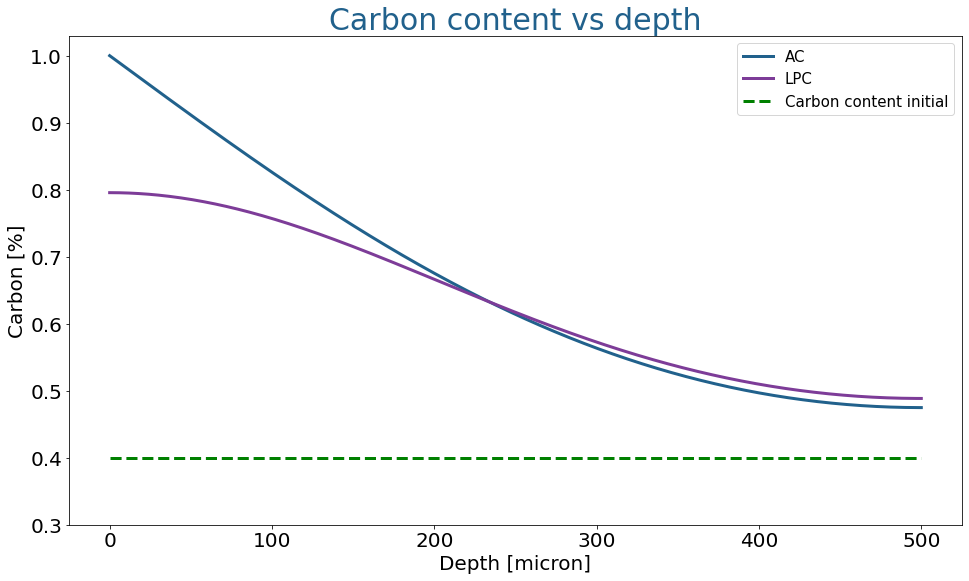

In [23]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
%matplotlib inline

plt.plot(depths,C_tracker_AC[-1,viz_nodes][::-1]*100,color='#21618c', linewidth=3,
        label='AC'
        )
plt.plot(depths,C_tracker_LPC[-1,viz_nodes][::-1]*100,color='#7d3c98', linewidth=3,
        label='LPC'
        )

ax=plt.gca()

# Horizontal line    
# plt.hlines(1.0,-0,500,linewidth=3, color='#feb24c', linestyles='dashed', 
#            label='Carbon potential environment'
#           )
plt.hlines(0.4,-0,500,linewidth=3, color='g', linestyles='dashed', 
           label='Carbon content initial'
          )

# Ticks
major_xticks = np.arange(0, 501,100)
major_yticks = np.arange(0.3, 1.1, 0.1)
ax.set_xticks(major_xticks)
ax.set_yticks(major_yticks)

# Decimal places on ticks
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # 0 decimal places
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 1 decimal places

# Ticks size
ax.tick_params(axis='x', which='major', labelsize=20)
ax.tick_params(axis='y', which='major', labelsize=20)

# Graph title
title = 'Carbon content vs depth'
plt.title(title, c= '#21618c', fontsize=30)

# Axes label
xlabel = 'Depth [micron]'
ylabel = 'Carbon [%]'
plt.xlabel(xlabel,fontsize=20)
plt.ylabel(ylabel,fontsize=20)

# Legends position
plt.legend(loc='best', fontsize=15)

# Figure size
fig_size = (16,9)
plt.gcf().set_size_inches(fig_size)
plt.show()

## Carbon and time

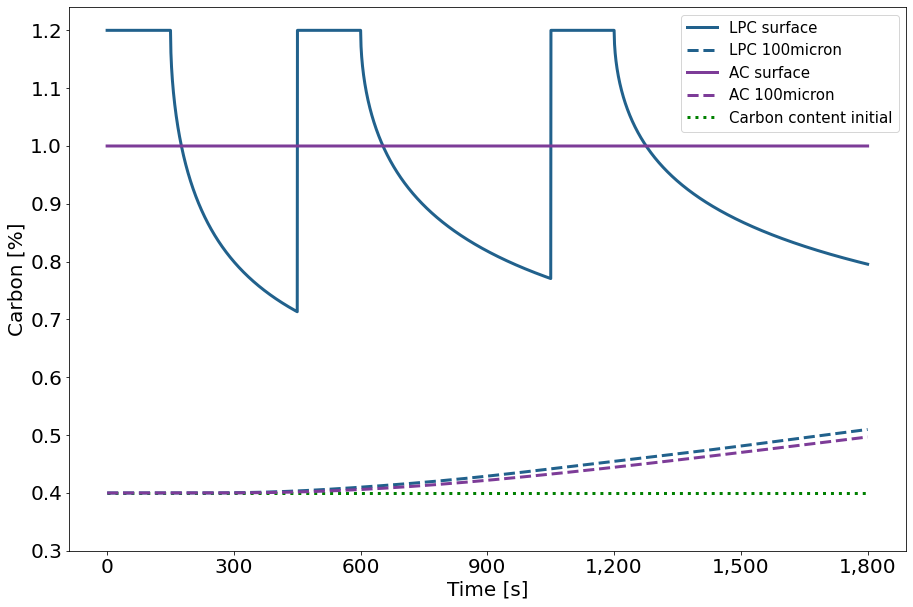

In [25]:
plt.plot(times,C_tracker_LPC[:,node_D0]*100,color='#21618c', linewidth=3,
        label = 'LPC surface')
plt.plot(times,C_tracker_LPC[:,node_D100]*100,color='#21618c', linewidth=3,
         ls = 'dashed',
        label = 'LPC 100micron')

plt.plot(times,C_tracker_AC[:,node_D0]*100,color='#7d3c98', linewidth=3,
        label = 'AC surface')
plt.plot(times,C_tracker_AC[:,node_D100]*100,color='#7d3c98', linewidth=3,
         ls = 'dashed',
        label = 'AC 100micron')

ax=plt.gca()

# Horizontal line

# plt.hlines(1.2,-0,1801,linewidth=3, color='#feb24c', linestyles='dashed', label='Carbon potential environment')
plt.hlines(0.4,-0,1801,linewidth=3, color='g', linestyles='dotted', label='Carbon content initial')

# Ticks
major_xticks = np.arange(0, 1801,300)
major_yticks = np.arange(0.3, 1.3, 0.1)
ax.set_xticks(major_xticks)
ax.set_yticks(major_yticks)

# Decimal places on ticks
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # 0 decimal places
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 1 decimal places

# Ticks size
ax.tick_params(axis='x', which='major', labelsize=20)
ax.tick_params(axis='y', which='major', labelsize=20)

# Graph title
title = ''
plt.title(title, c= 'tab:blue', fontsize=30)

# Axes label
xlabel = 'Time [s]'
ylabel = 'Carbon [%]'
plt.xlabel(xlabel,fontsize=20)
plt.ylabel(ylabel,fontsize=20)

# Legends position
plt.legend(loc='best', fontsize=15)

# Figure size
fig_size = (15,10)
plt.gcf().set_size_inches(fig_size)

plt.show()

# References

- [Solving PDEs in Python – The FEniCS Tutorial Volume I, by Hans Petter Langtangen and Anders Logg](https://fenicsproject.org/pub/tutorial/pdf/fenics-tutorial-vol1.pdf) 
<br><br>
- [CarbTool – Leading the Way in Case-Depth Simulations](https://www.industrialheating.com/articles/93091-carbtool---leading-the-way-in-case-depth-simulations)
<br><br>
- [Outstanding LPC Case Hardening of Pyrowear® Alloy 53](https://www.industrialheating.com/articles/92112-outstanding-lpc-case-hardening-of-pyrowear-alloy-53)